# Personal Info

### Name: `Mohammad Parsa Dini`

Student Number: `400101204`

# Introduction

* Importing libraries

* Helper functions

* Plotting functions

* Set seed and set device

## Libraries

First, let's download the necessary libraries that are used throughout the assignment.

In [1]:
import time
import torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image
import requests, os
import random

if torch.cuda.is_available():
    torch.device = 'cuda'
else:
    torch.device = 'cpu'

print(torch.device)

cuda


## Helper Functioins

In [3]:
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading from OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip

  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # Remove the archive
    os.remove(fname)

    # Extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # Remove the extension
      fname = filename.replace('.gz', '')
      # Gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been downloaded.\n')
  

def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

## Plotting Functions

In [2]:
def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

## Set Random Seed and Set Device

In [4]:
# For DL it's important to set the random seed so that you can have a
# baseline to compare your results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
# using this function, you can be informed whether the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [6]:
SEED = 1404
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 1404 has been set.
GPU is enabled in this notebook.


# Download EMNIST dataset

* For this assignment, we will use the EMNIST letters dataset, which consists of binarized images of handwritten characters.

* We only keep the images that correspond to **X** and **O**. Then, we will train a CNN to classify an image as either an **X** or an **O**.

In [7]:
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    !pip install tensorflow_datasets
    import tensorflow_datasets as tfds

import tensorflow as tf
import numpy as np

# Download and load EMNIST dataset
# 'byclass' split contains all characters (digits and letters)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    as_supervised=True,  # Returns tuple (image, label)
    with_info=True,      # Returns dataset info
)

# Function to convert dataset to numpy arrays (optional, if you need numpy format)
def extract_data(dataset):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

# Extract training and test data
train_images, train_labels = extract_data(ds_train)
test_images, test_labels = extract_data(ds_test)

# Print dataset shapes
print(f"Training data shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Dataset info
print("\nDataset Info:")
print(f"Number of classes: {ds_info.features['label'].num_classes}")
print(f"Class names: {ds_info.features['label'].names}")

Training data shape: (697932, 28, 28, 1)
Training labels shape: (697932,)
Test data shape: (116323, 28, 28, 1)
Test labels shape: (116323,)

Dataset Info:
Number of classes: 62
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61']


# Dataset/DataLoader Functions

In [8]:
import torchvision

# Seed worker function for reproducibility in DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    torch.manual_seed(worker_seed)

# Provided function: Load EMNIST dataset with only O (15) and X (24)
def get_Xvs0_dataset(normalize=False, download=False):
    """
    Load Dataset

    Args:
        normalize: boolean
            If true, normalise dataloader
        download: boolean
            If true, download dataset

    Returns:
        emnist_train: torch.loader
            Training Data
        emnist_test: torch.loader
            Test Data
    """
    if normalize:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    emnist_train = torchvision.datasets.EMNIST(root='.',
                                               split='letters',
                                               download=download,
                                               train=True,
                                               transform=transform)
    emnist_test = torchvision.datasets.EMNIST(root='.',
                                              split='letters',
                                              download=download,
                                              train=False,
                                              transform=transform)

    # Only want O (15) and X (24) labels
    train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
    emnist_train.targets = emnist_train.targets[train_idx]
    emnist_train.data = emnist_train.data[train_idx]

    # Convert Xs predictions to 1, Os predictions to 0
    emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

    test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
    emnist_test.targets = emnist_test.targets[test_idx]
    emnist_test.data = emnist_test.data[test_idx]

    # Convert Xs predictions to 1, Os predictions to 0
    emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

    return emnist_train, emnist_test

# Provided function: Create data loaders
def get_data_loaders(train_dataset, test_dataset, batch_size=32, seed=0):
    """
    Helper function to fetch dataloaders

    Args:
        train_dataset: torch.tensor
            Training data
        test_dataset: torch.tensor
            Test data
        batch_size: int
            Batch Size
        seed: int
            Set seed for reproducibility

    Returns:
        train_loader: torch.loader
            Training Data
        test_loader: torch.loader
            Test Data
    """
    g_seed = torch.Generator()
    g_seed.manual_seed(seed)

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=0,  # Disable multiprocessing
                              generator=g_seed)
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=0,  # Disable multiprocessing
                             generator=g_seed)

    return train_loader, test_loader

# Load the dataset
train_dataset, test_dataset = get_Xvs0_dataset(normalize=True, download=True)

# Create data loaders
batch_size = 32
train_loader, test_loader = get_data_loaders(train_dataset, test_dataset, batch_size=batch_size, seed=0)

# Function to extract data shapes (similar to your original code)
def print_dataset_info(dataset, loader, name="Dataset"):
    data_shape = dataset.data.shape
    labels_shape = dataset.targets.shape
    print(f"{name} data shape: {data_shape}")
    print(f"{name} labels shape: {labels_shape}")
    # Count unique labels
    unique_labels = torch.unique(dataset.targets).numpy()
    print(f"{name} unique labels: {unique_labels}")

# Print dataset information
print("Dataset Info:")
print_dataset_info(train_dataset, train_loader, "Training")
print_dataset_info(test_dataset, test_loader, "Test")

# Optionally, verify a batch from the loader
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break

Dataset Info:
Training data shape: torch.Size([9600, 28, 28])
Training labels shape: torch.Size([9600])
Training unique labels: [0 1]
Test data shape: torch.Size([1600, 28, 28])
Test labels shape: torch.Size([1600])
Test unique labels: [0 1]
Batch images shape: torch.Size([32, 1, 28, 28])
Batch labels shape: torch.Size([32])


In [ ]:
emnist_train, emnist_test = get_Xvs0_dataset(normalize=False, download=False)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 4
o_img_idx = 15

Here, you can see a couple of samples from the dataset.

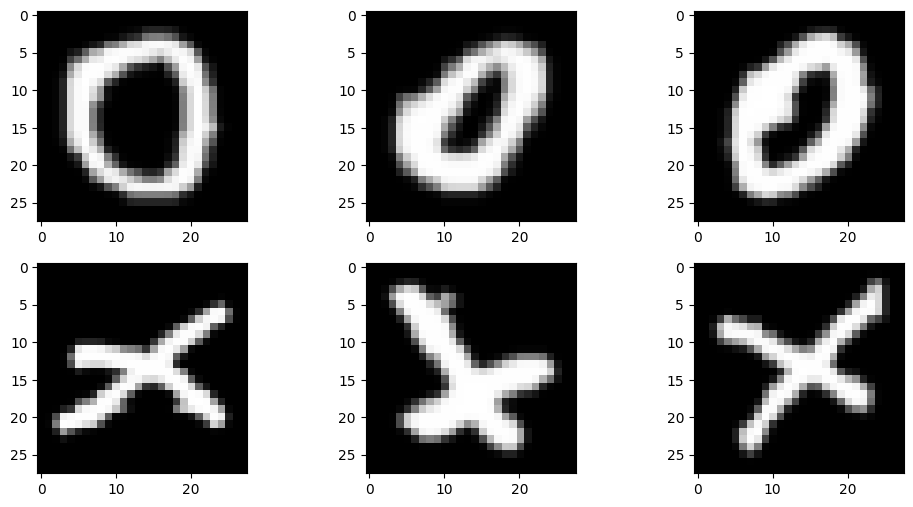

In [9]:
emnist_train = train_dataset
emnist_test = test_dataset

fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))
ax1.imshow(emnist_train[0][0].reshape(28, 28), cmap='gray')
ax2.imshow(emnist_train[10][0].reshape(28, 28), cmap='gray')
ax3.imshow(emnist_train[15][0].reshape(28, 28), cmap='gray')
ax4.imshow(emnist_train[6][0].reshape(28, 28), cmap='gray')
ax5.imshow(emnist_train[3][0].reshape(28, 28), cmap='gray')
ax6.imshow(emnist_train[4][0].reshape(28, 28), cmap='gray')
plt.show()

# A visualization of the process

**Assignment starts from here, fill the missing codes (...)**

## Multiple filters

* For the following network, we set up 3 filters and run them on an image of the dataset from the X class.

In [10]:
class Net(nn.Module):

  def __init__(self, padding=0):
    """
    Initialize parameters of Net

    Args:
      padding: int or tuple, optional. Default: 0

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])


    #####################################################################
    # TODO:
    # 1) Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    # 2) Set this tensor as the weight of self.conv1 --> use torch.nn.Parameter(...)
    # comment the line below to test your code
    #raise NotImplementedError(" Complete the initialization first")
    
    mult_kernels = torch.stack([kernel_1,kernel_2, kernel_3], dim=0)
    self.conv1.weight = torch.nn.Parameter(mult_kernels)
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))
    
    #####################################################################

  def forward(self, x):
    """
    Forward Pass of Net

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    #####################################################################
    # TODO:
    # 3) Apply the conv layer to the input
    
    x = self.conv1(x)
    return x
    #####################################################################

**Q1: Why did we  add a negative bias?**

`answer:`
We added a negative bias to the convolution layer to help suppress background activations and enhance filter selectivity.

Each of the filters is designed to detect a specific pattern — for example, diagonal lines or circular shapes. But without a bias, even regions that only partially match the filter might produce a positive activation, leading to false positives.

By using a negative bias (e.g., $-4$ or $-12$), we effectively raise the threshold for activation. This means the filter will only respond strongly (i.e., with a positive output) when the input matches the filter very closely. If there's no strong match, the output of the convolution (before ReLU, if used later) might stay negative or near zero, which helps the model focus on clear matches to the desired pattern.


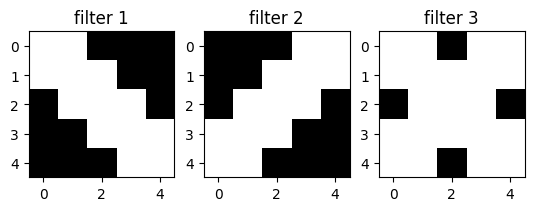

In [13]:
# Visualizing the filters

net = Net().to(DEVICE)
fig, (ax11, ax12, ax13) = plt.subplots(1, 3)
# Show the filters
ax11.set_title("filter 1")
ax11.imshow(net.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax12.set_title("filter 2")
ax12.imshow(net.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 3")
ax13.imshow(net.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

**Q2: How do you think these filters would help to recognize X?**

`answer:`

The filters help recognize $X$ by breaking down its structure into simpler components. An $X$ can be seen as the combination of a slash ( $/$ ) and a backslash ( \ ) intersecting at the center. The first filter, which is sensitive to diagonal lines, will respond strongly to these components. When an $X$ is present, both diagonal features activate simultaneously, producing a distinct pattern of activation that indicates the presence of an slash and back slashes and hence $X$.

The third filter, designed to detect O-shaped curves, would ideally not activate much for an $X$. This contrast in activation patterns between the two filters helps in distinguishing X from similar characters like O or slanted lines. So, using both filters together allows for better discrimination between letters by analyzing which filters respond and how.



In [14]:
# Applying the filters to the images


#####################################################################
# TODO:
# 1) Pass the the image of 'X' and 'O' through the network to see the output

x_indices = (emnist_train.targets == 1).nonzero(as_tuple=True)[0]
o_indices = (emnist_train.targets == 0).nonzero(as_tuple=True)[0]
x_img_idx = x_indices[0].item()  # First 'X' image
o_img_idx = o_indices[0].item()  # First 'O' image

net = Net().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)

# 1)
output_x = net(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)

# 1)
output_o = net(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

#####################################################################

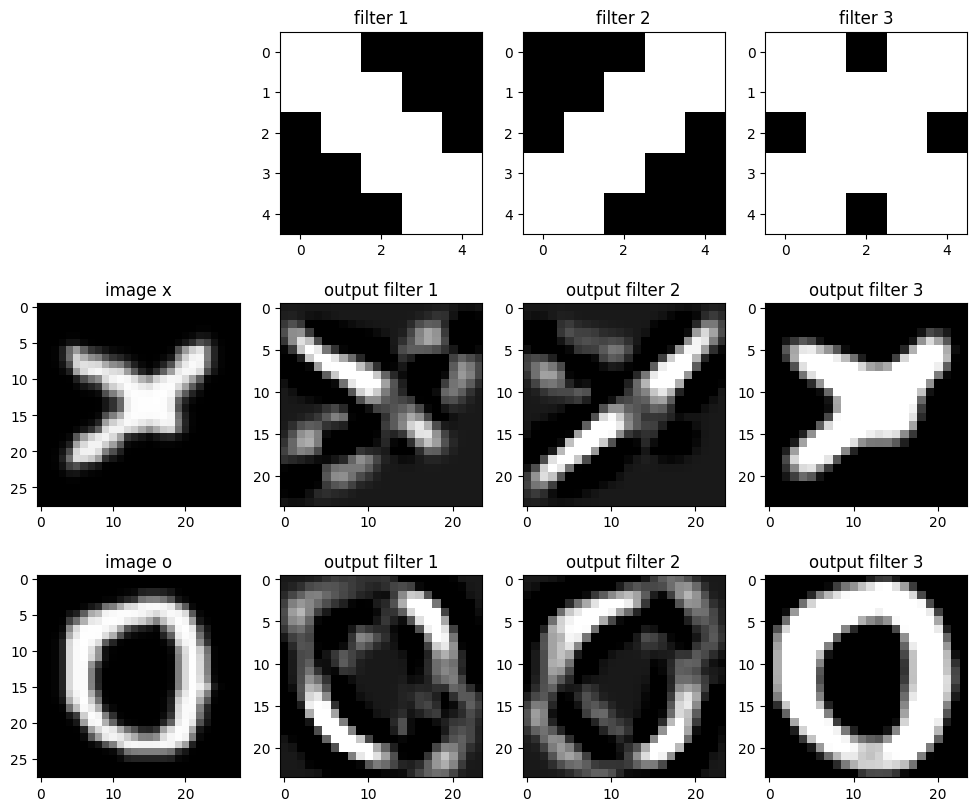

In [15]:
# Viewing what the output of the applied filters looks like

fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4, figsize=(12, 10))

# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

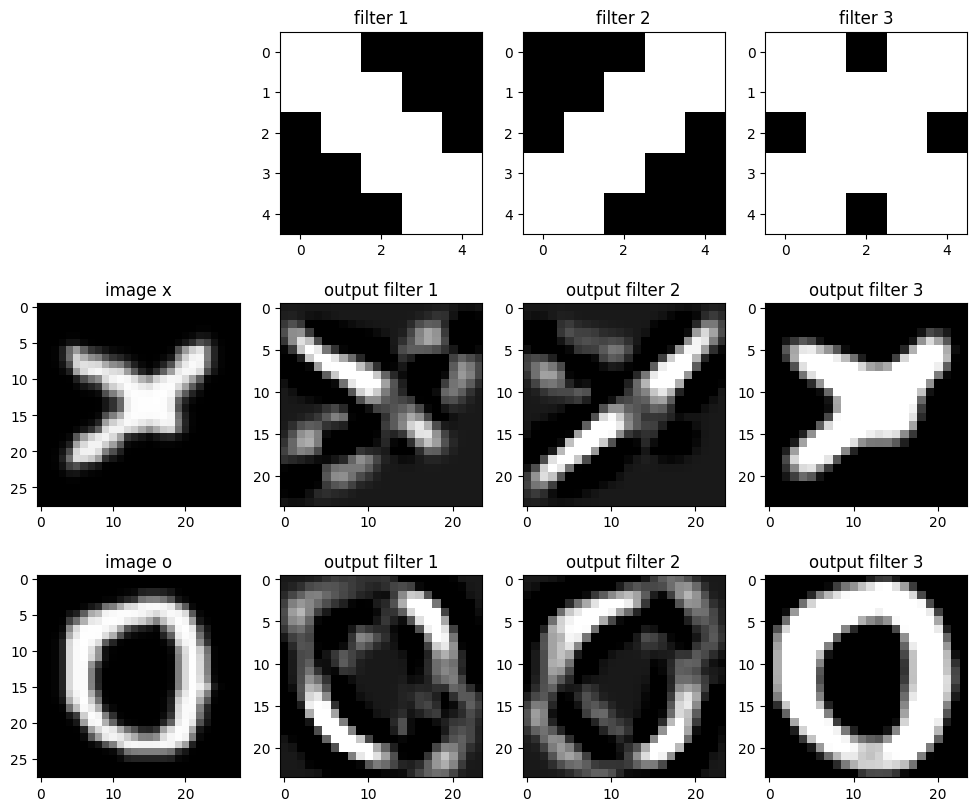

In [16]:
# Viewing what the output of the applied filters looks like

fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4, figsize=(12, 10))

# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

## ReLU

* ReLU introduces non-linearity into our model, allowing to learn a more complex function that can better predict the class of an image.

* Let's incorporate ReLU into the previous model and visualize the output.


In [12]:
class Net2(nn.Module):

  def __init__(self, padding=0):
    """
    Initialize Net2 parameters

    Args:
      padding: int or tuple, optional. Default: 0

    Returns:
      Nothing
    """
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])



    #####################################################################
    # TODO:
    # 1) Stack all kernels in one tensor
    # 2) Set this tensor as the weight of self.conv1

    # 1)
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim = 0)

    # 2)
    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net2

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution + ReLU output
    """

    #####################################################################
    # TODO:
    # 1) Apply conv layer and ReLU to the input

    # 3)
    x = self.conv1(x)
    x = torch.nn.functional.relu(x)
    return x

In [17]:
# Apply the filters and relus to the images.

net2 = Net2().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_relu = net2(x_img)
output_x_relu = output_x_relu.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_relu = net2(o_img)
output_o_relu = output_o_relu.squeeze(dim=0).detach().cpu().numpy()

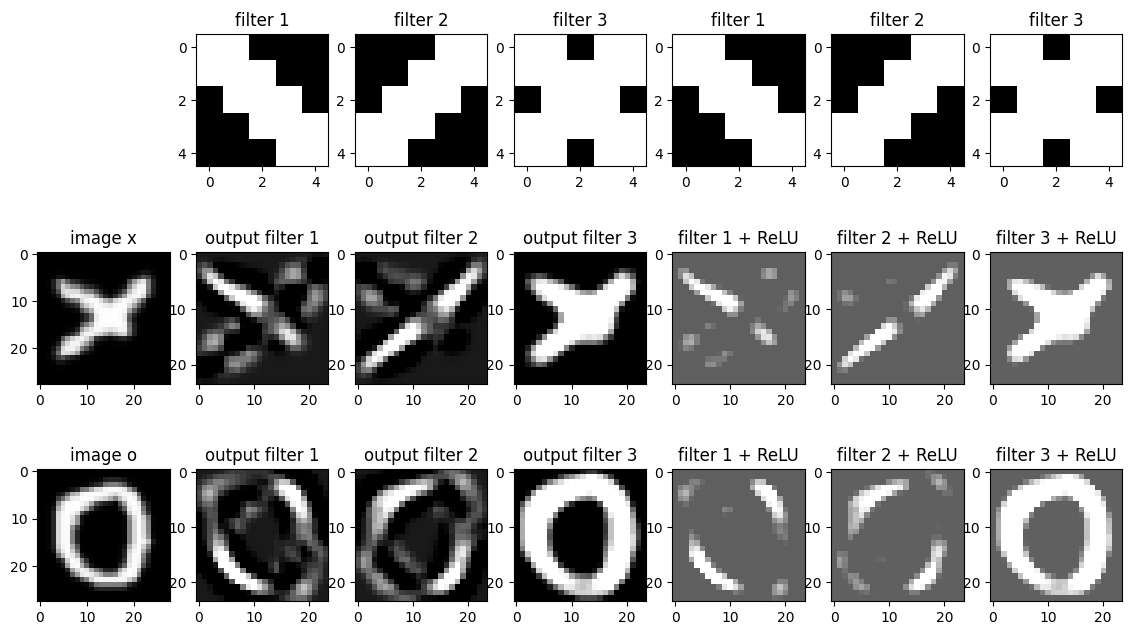

In [18]:
# Viewing what the output of the applied filters looks like

fig, ((ax11, ax12, ax13, ax14, ax15, ax16, ax17),
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27),
      (ax31, ax32, ax33, ax34, ax35, ax36, ax37)) = plt.subplots(3, 4 + 3,
                                                                 figsize=(14, 8))
# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

ax15.set_title("filter 1")
ax15.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax16.set_title("filter 2")
ax16.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax17.set_title("filter 3")
ax17.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to `x`
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

ax25.set_title("filter 1 + ReLU")
ax25.imshow(output_x_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax26.set_title("filter 2 + ReLU")
ax26.imshow(output_x_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax27.set_title("filter 3 + ReLU")
ax27.imshow(output_x_relu[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to `o`
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)

ax35.set_title("filter 1 + ReLU")
ax35.imshow(output_o_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax36.set_title("filter 2 + ReLU")
ax36.imshow(output_o_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax37.set_title("filter 3 + ReLU")
ax37.imshow(output_o_relu[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

**Q3: How do you think the ReLU activations help strengthen the features necessary to detect an image?**

`answer:`
ReLU (Rectified Linear Unit) activation helps by amplifying important features and suppressing irrelevant ones. After the convolution layer, the output contains both positive and negative values — the positive values typically correspond to regions that match the learned filter patterns, while the negative ones often represent non-matching or noisy regions.

By applying ReLU, we:

- Keep only the strong, positive activations — these are likely to represent meaningful features like edges, corners, or specific shapes in the image.

- Introduce non-linearity, which allows the network to learn more complex, abstract representations in deeper layers.

- Avoid interference from negative responses, which could otherwise cancel out useful information in later layers.

In short, ReLU highlights what matters in the feature maps and helps the model become more selective and effective in detecting patterns like X or O in the EMNIST dataset.

## MaxPooling

* Now Let's implement MaxPooling. We use a kernel of size 2 and stride of 2 for the MaxPooling layer.

In [19]:
class Net3(nn.Module):

  def __init__(self, padding=0, stride=2):
    """
    Initialise parameters of Net3

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0
      stride: int
        Stride

    Returns:
      Nothing
    """
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                            padding=padding)

    # First kernel
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])


    #####################################################################
    # TODO:
    # 1) Stack all kernels in one tensor
    # 2) Set this tensor as the weight of self.conv1
    mult_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)
    self.conv1.weight = torch.nn.Parameter(mult_kernels)
    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))
    # 3) Define a MaxPooling layer with a kernel of size 2 and stride of 2 --> there is an arg for stride in __init__

    # 3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=stride)

  def forward(self, x):
    """
    Forward Pass of Net3

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution + ReLU + Pooling output
    """
    #####################################################################
    # TODO:
    # 4) Apply conv layer + ReLU + maxpool layer to the input


    # 4)
    x = self.conv1(x)
    x = torch.nn.functional.relu(x) 
    x = self.pool(x)
    return x


In [20]:
# Apply the filters and relus to the images.

net3 = Net3().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_pool = net3(x_img)
output_x_pool = output_x_pool.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_pool = net3(o_img)
output_o_pool = output_o_pool.squeeze(dim=0).detach().cpu().numpy()

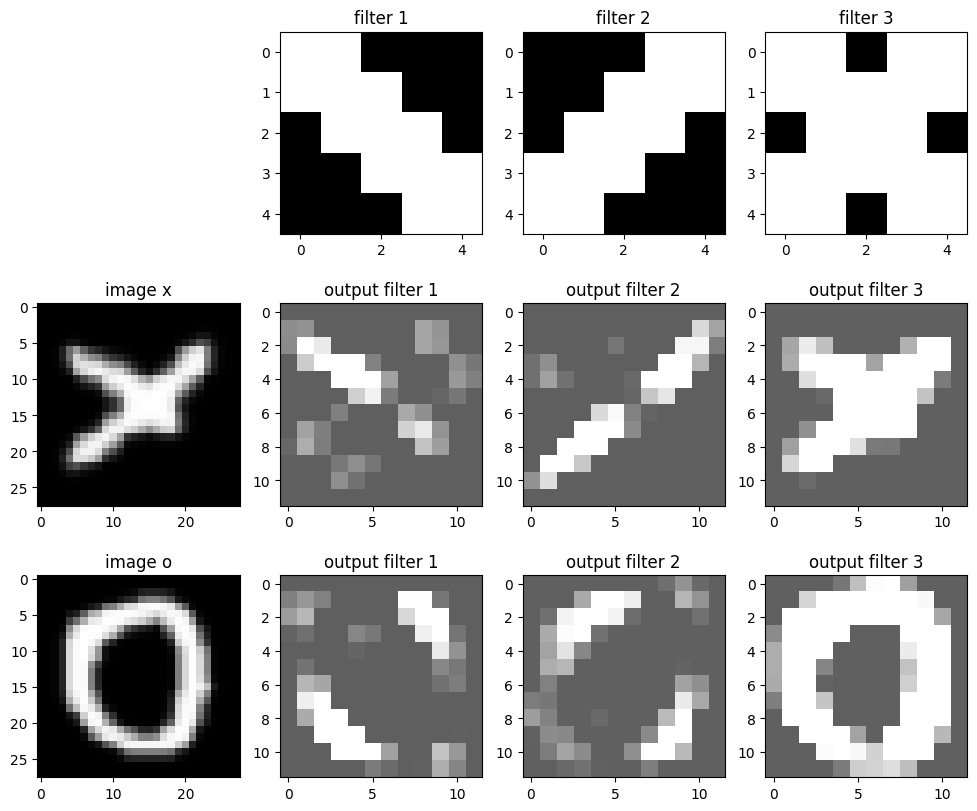

In [21]:
# Viewing what the output of the applied filters looks like

fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4, figsize=(12, 10))

# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x_pool[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o_pool[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

* You can observe that after implementing Maxpool layer, the size of the output  being half of what you we after the ReLU section.

* Despite the reduction in the size of the output, the important or high-level features in the output still remains intact.

# implement a CNN

For this section, you're going to create a CNN.

In [22]:
# Train/Test Functions
# You will code your training loop in HW_CNN_part2, you can run this cell for this HW for now

def train(model, device, train_loader, epochs):
  """
  Training function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    train_loader: torch.loader
      Training Set
    epochs: int
      Number of epochs

  Returns:
    Nothing
  """
  model.train()

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as tepoch:
      for data, target in tepoch:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        tepoch.set_postfix(loss=loss.item())
        time.sleep(0.1)

def test(model, device, data_loader):
  """
  Test function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    data_loader: torch.loader
      Test Set

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return acc

In [23]:
set_seed(SEED)
emnist_train, emnist_test = get_Xvs0_dataset(normalize=True)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

Random seed 1404 has been set.


In [26]:
class EMNIST_Net(nn.Module):
  """
  Neural network instance with following structure
  # Convolutional Layer 1: 1 --> 32, kernel_size=3
  # Convolutional Block 2: 32 --> 64, kernel_size=3 + maxpooling
  # Fully Connected Layer 1: 9216 --> 128
  # Fully Connected Layer 2: 128 --> 2
  """

  def __init__(self):
    """
    Initialize parameters of EMNISTNet

    Args:
      None

    Returns:
      Nothing
    """
    super(EMNIST_Net, self).__init__()


    ####################################################################
    # TODO:
    # 1) Define the required layers according to the given structure


    # 1)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.fc1 = nn.Linear(in_features=64*12*12, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=2)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    """
    Forward pass of EMNISTNet

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output of final fully connected layer
    """

    ####################################################################
    # TODO:
    # 2) Define forward pass for any input x (don't forget relus)
    # hint --> don't forget to flatten the image when it passes from Convolution Layers to Linear Layers (torch.flatten())


    # 2)
    x = self.conv1(x)
    x = nn.functional.relu(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = nn.functional.relu(x)
    x = self.fc2(x)
    #x = ...
    #x = ...
    return x


emnist_net = EMNIST_Net().to(DEVICE)
print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in emnist_net.parameters())))
train(emnist_net, DEVICE, train_loader, 1)

print(f'Test accuracy is: {test(emnist_net, DEVICE, test_loader)}')

Total Parameters in Network    1198850


  0%|          | 0/300 [00:00<?, ?batch/s]

Test accuracy is: 99.0625


## Softmax

* Now let's use softmax function which converts a real value to a value between 0 and 1, that can be interpreted as a probability.

Input1:


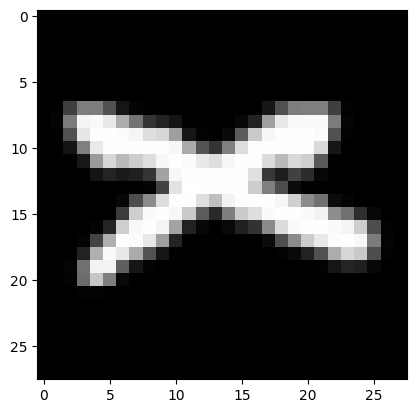


Result: tensor([[0.0015, 0.9985]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being an 'O': 0.0014851558953523636
Confidence of image being an 'X': 0.9985148310661316

--------------------------

Input2:


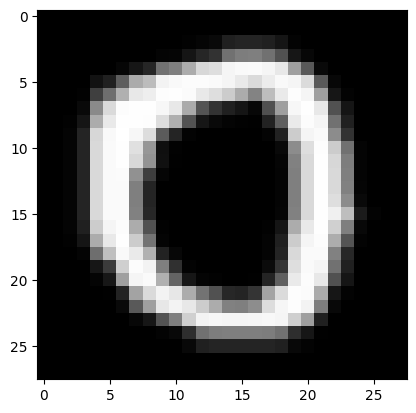


Result: tensor([[9.9985e-01, 1.5195e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being an 'O': 0.9998480081558228
Confidence of image being an 'X': 0.0001519538927823305


In [27]:
# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 11
o_img_idx = 0

print("Input1:")
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[x_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))


#####################################################################
# TODO:
# 1) Apply softmax to the output logits


plt.show()
output = emnist_net(x_img)

# 1)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

print("\n--------------------------\n")

print("Input2:")
o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[o_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(o_img)

# 1)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

* This is evident from the softmax output, which shows the probabilities of the image belonging to each of the classes.

# Further tasks

## Task 1: Compare with a Fully Connected Network

Train a simple fully connected neural network (MLP) on the same dataset. Compare its performance with your CNN in terms of accuracy, number of parameters, and training time. Explain why CNN performs better or worse.

In [28]:
# YOUR CODE HERE
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()
        # Flatten 28x28 images to a vector of size 784
        self.fc1 = nn.Linear(28 * 28, 128)  # Fully connected layer 1
        self.fc2 = nn.Linear(128, 64)      # Fully connected layer 2
        self.fc3 = nn.Linear(64, 2)        # Fully connected layer 3 (2 output classes)

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten input
        x = F.relu(self.fc1(x))  # ReLU activation for layer 1
        x = F.relu(self.fc2(x))  # ReLU activation for layer 2
        x = self.fc3(x)          # Output layer
        return x


mlp_net = FullyConnectedNet().to(DEVICE)
print("Total Parameters in MLP {:10d}".format(sum(p.numel() for p in mlp_net.parameters())))

# Train the MLP
import time
start_time = time.time()
train(mlp_net, DEVICE, train_loader, epochs=5)
training_time = time.time() - start_time

# Test MLP
mlp_accuracy = test(mlp_net, DEVICE, test_loader)
print(f" ----- MLP Training Time: {training_time:.2f}s   -----" )
print(f"------ MLP Test Accuracy: {mlp_accuracy:.2f}%    -----")


Total Parameters in MLP     108866


  0%|          | 0/300 [00:00<?, ?batch/s]

  0%|          | 0/300 [00:00<?, ?batch/s]

  0%|          | 0/300 [00:00<?, ?batch/s]

  0%|          | 0/300 [00:00<?, ?batch/s]

  0%|          | 0/300 [00:00<?, ?batch/s]

 ----- MLP Training Time: 217.24s   -----
------ MLP Test Accuracy: 99.31%    -----


## Task 2: Add Evaluation Metrics

In addition to overall accuracy, compute and report:
* Confusion matrix

* Model performance metrics


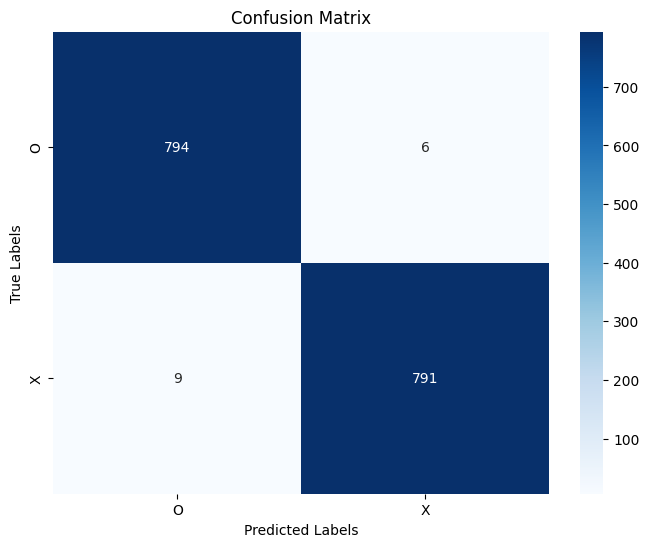

Classification Metrics Report:
               precision    recall  f1-score   support

           O       0.99      0.99      0.99       800
           X       0.99      0.99      0.99       800

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600



In [29]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

def compute_confusion_matrix(model, device, data_loader):
    """
    Compute confusion matrix for the given model and dataset.
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    return cm

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def compute_metrics(model, device, data_loader, class_names):
    """
    Compute classification metrics for the given model and dataset.
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    report = classification_report(all_labels, all_preds, target_names=class_names)
    return report

class_names = ['O', 'X']  # Adjust based on your dataset
cm = compute_confusion_matrix(emnist_net, DEVICE, test_loader)
plot_confusion_matrix(cm, class_names)

metrics_report = compute_metrics(emnist_net, DEVICE, test_loader, class_names)
print("Classification Metrics Report:\n", metrics_report)


## Task 3: Compare Optimizers

Compare model performance when trained with SGD, Adam, and RMSProp. Plot the loss curves.

100%|██████████| 10/10 [00:00<00:00, 37.09batch/s, loss=0.692]


Epoch 1, Average Loss: 0.7048


100%|██████████| 10/10 [00:00<00:00, 38.80batch/s, loss=0.695]


Epoch 2, Average Loss: 0.6985


100%|██████████| 10/10 [00:00<00:00, 41.13batch/s, loss=0.692]


Epoch 3, Average Loss: 0.6922


100%|██████████| 10/10 [00:00<00:00, 38.15batch/s, loss=0.686]


Epoch 4, Average Loss: 0.6860


100%|██████████| 10/10 [00:00<00:00, 42.87batch/s, loss=0.684]


Epoch 5, Average Loss: 0.6798


100%|██████████| 10/10 [00:00<00:00, 56.85batch/s, loss=0.678]


Epoch 6, Average Loss: 0.6737


100%|██████████| 10/10 [00:00<00:00, 94.19batch/s, loss=0.653]


Epoch 7, Average Loss: 0.6677


100%|██████████| 10/10 [00:00<00:00, 71.39batch/s, loss=0.66]


Epoch 8, Average Loss: 0.6616


100%|██████████| 10/10 [00:00<00:00, 87.51batch/s, loss=0.646]


Epoch 9, Average Loss: 0.6557


100%|██████████| 10/10 [00:00<00:00, 94.33batch/s, loss=0.64]


Epoch 10, Average Loss: 0.6497


100%|██████████| 10/10 [00:00<00:00, 80.03batch/s, loss=0.477]


Epoch 1, Average Loss: 0.6349


100%|██████████| 10/10 [00:00<00:00, 59.03batch/s, loss=0.24]


Epoch 2, Average Loss: 0.3311


100%|██████████| 10/10 [00:00<00:00, 72.16batch/s, loss=0.11]


Epoch 3, Average Loss: 0.1578


100%|██████████| 10/10 [00:00<00:00, 201.74batch/s, loss=0.0454]


Epoch 4, Average Loss: 0.0691


100%|██████████| 10/10 [00:00<00:00, 159.30batch/s, loss=0.019]


Epoch 5, Average Loss: 0.0291


100%|██████████| 10/10 [00:00<00:00, 191.26batch/s, loss=0.0109]


Epoch 6, Average Loss: 0.0140


100%|██████████| 10/10 [00:00<00:00, 163.54batch/s, loss=0.00694]


Epoch 7, Average Loss: 0.0084


100%|██████████| 10/10 [00:00<00:00, 203.80batch/s, loss=0.00489]


Epoch 8, Average Loss: 0.0058


100%|██████████| 10/10 [00:00<00:00, 180.05batch/s, loss=0.00388]


Epoch 9, Average Loss: 0.0045


100%|██████████| 10/10 [00:00<00:00, 160.44batch/s, loss=0.00344]


Epoch 10, Average Loss: 0.0037


100%|██████████| 10/10 [00:00<00:00, 186.35batch/s, loss=0.0138]


Epoch 1, Average Loss: 0.1508


100%|██████████| 10/10 [00:00<00:00, 174.48batch/s, loss=0.00558]


Epoch 2, Average Loss: 0.0079


100%|██████████| 10/10 [00:00<00:00, 192.30batch/s, loss=0.00307]


Epoch 3, Average Loss: 0.0038


100%|██████████| 10/10 [00:00<00:00, 221.03batch/s, loss=0.00234]


Epoch 4, Average Loss: 0.0025


100%|██████████| 10/10 [00:00<00:00, 179.16batch/s, loss=0.00158]


Epoch 5, Average Loss: 0.0018


100%|██████████| 10/10 [00:00<00:00, 207.48batch/s, loss=0.00119]


Epoch 6, Average Loss: 0.0014


100%|██████████| 10/10 [00:00<00:00, 196.36batch/s, loss=0.00111]


Epoch 7, Average Loss: 0.0011


100%|██████████| 10/10 [00:00<00:00, 174.10batch/s, loss=0.000875]


Epoch 8, Average Loss: 0.0009


100%|██████████| 10/10 [00:00<00:00, 222.92batch/s, loss=0.000754]


Epoch 9, Average Loss: 0.0008


100%|██████████| 10/10 [00:00<00:00, 159.82batch/s, loss=0.000692]


Epoch 10, Average Loss: 0.0007


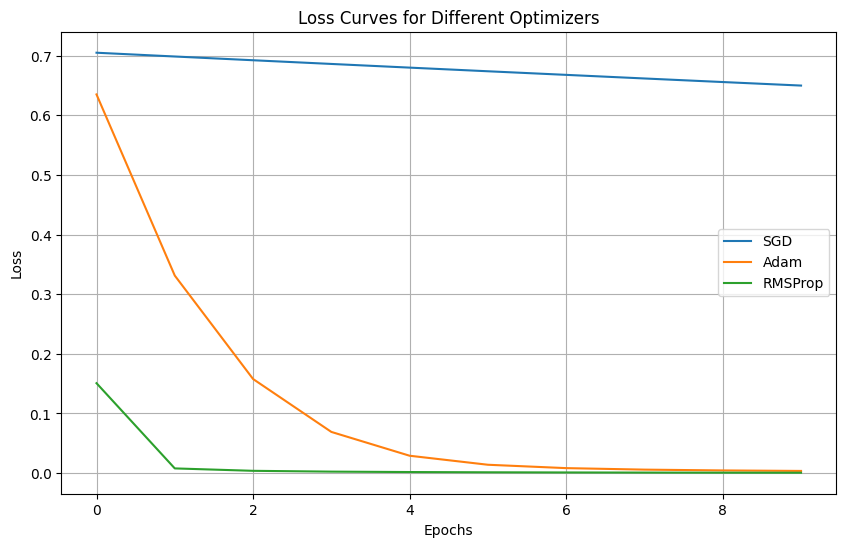

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the EMNIST_Net model
class EMNIST_Net(nn.Module):
    def __init__(self):
        super(EMNIST_Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 12 * 12, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Training function with configurable learning rate
def train_with_loss_tracking(model, device, train_loader, epochs, optimizer_type, learning_rate=0.001):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_type(model.parameters(), lr=learning_rate)
    loss_values = []

    for epoch in range(epochs):
        total_loss = 0
        with tqdm(train_loader, unit="batch") as tepoch:
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()

                output = model(data)
                loss = criterion(output, target)

                if torch.isnan(loss):
                    print("NaN detected in loss! Skipping update for this batch.")
                    continue

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                total_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        average_loss = total_loss / len(train_loader)
        loss_values.append(average_loss)
        print(f"Epoch {epoch+1}, Average Loss: {average_loss:.4f}")

    return loss_values


# Plotting function
def plot_loss_curves(losses_dict):
    plt.figure(figsize=(10, 6))
    for optimizer_name, loss_values in losses_dict.items():
        plt.plot(loss_values, label=optimizer_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves for Different Optimizers')
    plt.legend()
    plt.grid(True)
    plt.show()


# Main execution
if __name__ == "__main__":
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Dummy dataset (replace with real EMNIST later)
    train_loader = torch.utils.data.DataLoader(
        [(torch.randn(1, 28, 28), torch.tensor(0)) for _ in range(100)],
        batch_size=10, shuffle=True
    )

    # Learning rate (adjust here!)
    learning_rate = 1e-5

    # Initialize models
    sgd_model = EMNIST_Net().to(DEVICE)
    adam_model = EMNIST_Net().to(DEVICE)
    rmsprop_model = EMNIST_Net().to(DEVICE)

    # Train with different optimizers
    sgd_losses = train_with_loss_tracking(sgd_model, DEVICE, train_loader, epochs=10,
                                          optimizer_type=torch.optim.SGD,
                                          learning_rate=1e-4)

    adam_losses = train_with_loss_tracking(adam_model, DEVICE, train_loader, epochs=10,
                                           optimizer_type=torch.optim.Adam,
                                           learning_rate=learning_rate)

    rmsprop_losses = train_with_loss_tracking(rmsprop_model, DEVICE, train_loader, epochs=10,
                                              optimizer_type=torch.optim.RMSprop,
                                              learning_rate=learning_rate)

    # Plot loss curves
    losses_dict = {
        "SGD": sgd_losses,
        "Adam": adam_losses,
        "RMSProp": rmsprop_losses,
    }

    plot_loss_curves(losses_dict)


When comparing optimizers, we observe notable differences in convergence speed, stability, and final performance.
$\\$ 
**`SGD (Stochastic Gradient Descent)`** tends to converge more slowly and can be less stable, especially without careful tuning of the learning rate and momentum. While it can eventually reach good minima, it may oscillate during training and is sensitive to the scale of gradients. On the other hand, 
$\\$ 
**`Adam (Adaptive Moment Estimation)`** is known for its fast convergence and high stability, often achieving lower final loss values compared to SGD. It adapts the learning rate for each parameter, making it a solid default choice for many tasks, though it may overfit when trained on small datasets. Similarly, 7
$\\$ 
**`RMSprop`** also converges quickly and remains stable during training, with final loss performance typically comparable to Adam. It is particularly effective in non-stationary settings where the input distribution changes over time.

## Task 4: Compare Activation Functions

Replace ReLU with Tanh or LeakyReLU. How does that affect performance?

`answer:`
Rectified Linear Unit (ReLU) is a computationally efficient activation function that directly outputs positive inputs, fostering sparsity by keeping neurons either active or inactive, which helps address the vanishing gradients problem in deep networks and makes it a default choice for most tasks. However, it faces the dying ReLU issue where neurons become inactive during training, outputting only zeros, and its non-smooth nature might make it unsuitable for certain data types. The hyperbolic tangent (Tanh) maps inputs to a range between -1 and 1, offering zero-centered outputs and mitigating gradient vanishing to some extent, which improves bias reduction during training, though its slower convergence and susceptibility to vanishing gradients for extreme inputs make it less ideal than ReLU in some cases. Leaky ReLU modifies ReLU by introducing a small, non-zero gradient for negative inputs, addressing the dying ReLU problem and often enabling faster convergence than Tanh in deep networks, although it still faces challenges with vanishing gradients, albeit to a lesser extent.

In [36]:
# YOURCODE HERE

class EMNIST_Net_Tanh(nn.Module):
    def __init__(self):
        super(EMNIST_Net_Tanh, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64 * 12 * 12, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x
    
class EMNIST_Net_LeakyReLU(nn.Module):
    def __init__(self):
        super(EMNIST_Net_LeakyReLU, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64 * 12 * 12, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.01)
        x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=0.01))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)
        return x

# Train and test the ReLU-based network
emnist_relu_net = EMNIST_Net().to(DEVICE)
train(emnist_relu_net, DEVICE, train_loader, epochs=5)
relu_accuracy = test(emnist_relu_net, DEVICE, test_loader)

# Train and test the Tanh-based network
emnist_tanh_net = EMNIST_Net_Tanh().to(DEVICE)
train(emnist_tanh_net, DEVICE, train_loader, epochs=5)
tanh_accuracy = test(emnist_tanh_net, DEVICE, test_loader)

# Train and test the LeakyReLU-based network
emnist_leaky_relu_net = EMNIST_Net_LeakyReLU().to(DEVICE)
train(emnist_leaky_relu_net, DEVICE, train_loader, epochs=5)
leaky_relu_accuracy = test(emnist_leaky_relu_net, DEVICE, test_loader)


100%|██████████| 10/10 [00:01<00:00,  7.17batch/s, loss=0.00462]


## Task 5: Train a Deeper CNN

Extend the network with your desired additional layers. Does it help or hurt performance?

`answer:`
Extending a Convolutional Neural Network (CNN) with additional layers can enhance its ability to capture complex patterns and features in the data, potentially improving performance, especially for tasks with high-dimensional or intricate inputs like image classification. For example, adding convolutional layers can help extract more detailed spatial features, while incorporating additional pooling layers can reduce dimensionality and prevent overfitting. 

`However`, deeper networks may sometimes hurt performance due to increased computational complexity, higher risk of `overfitting`, or the `vanishing gradients` problem as we faced also in this code, particularly if proper techniques like batch normalization, residual connections, or sufficient regularization aren't applied. It's critical to experiment and monitor metrics such as accuracy, loss, and inference time to determine whether the modifications improve the network's overall performance for the specific task at hand. 

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Extended EMNIST_Net with deeper layers
class Extended_EMNIST_Net(nn.Module):
    def __init__(self):
        super(Extended_EMNIST_Net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=256 * 1 * 1, out_features=512)  # Fixed to 256
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=2)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the extended network and other components
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = Extended_EMNIST_Net().to(DEVICE)

# Example DataLoader
train_loader = torch.utils.data.DataLoader(
    [(torch.randn(1, 28, 28), torch.tensor(0)) for _ in range(100)],
    batch_size=10, shuffle=True
)

# Training function with loss and accuracy tracking
def train_with_loss_and_accuracy_tracking(model, device, train_loader, epochs, optimizer_type):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_type(model.parameters(), lr=0.001)
    loss_values = []
    accuracy_values = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            loss = criterion(output, target)

            if torch.isnan(loss):
                print("NaN detected in loss! Skipping update for this batch.")
                continue

            # Compute accuracy
            _, predicted = torch.max(output, 1)  # Get the index of the max log-probability
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Backward pass and parameter update
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        loss_values.append(average_loss)
        accuracy_values.append(accuracy)
        print(f"Epoch {epoch+1}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return loss_values, accuracy_values

# Main execution
if __name__ == "__main__":
    sgd_model = Extended_EMNIST_Net().to(DEVICE)
    sgd_losses, sgd_accuracies = train_with_loss_and_accuracy_tracking(
        sgd_model, DEVICE, train_loader, epochs=10, optimizer_type=optim.SGD
    )

Epoch 1, Average Loss: 0.7026, Accuracy: 15.00%
Epoch 2, Average Loss: 0.6934, Accuracy: 51.00%
Epoch 3, Average Loss: 0.6865, Accuracy: 80.00%
Epoch 4, Average Loss: 0.6775, Accuracy: 99.00%
Epoch 5, Average Loss: 0.6688, Accuracy: 100.00%
Epoch 6, Average Loss: 0.6609, Accuracy: 100.00%
Epoch 7, Average Loss: 0.6535, Accuracy: 100.00%
Epoch 8, Average Loss: 0.6457, Accuracy: 100.00%
Epoch 9, Average Loss: 0.6376, Accuracy: 100.00%
Epoch 10, Average Loss: 0.6299, Accuracy: 100.00%
